# imports

In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [22]:
from sentinelhub import SHConfig
config = SHConfig()

In [34]:
#create an client and instance on sentinal-hub
config.sh_client_id = '1543b9e6-3abf-441b-9f19-0c8b70b925b2'
config.sh_client_secret = 'J2H.z_4ENpdQomb)Q1t*f-u?Zh<{)TH1Cd4JmQMv'
config.instance_id = "d6043a1f-543a-453e-acd6-8f90b6b74f56"
config.save()

In [24]:
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [25]:
from sentinelhub import (
    CRS,
    BBox,
    Geometry,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# Setting area of interest

In [26]:
poly = [[7.090278,80.554440],[7.090278,80.554170],[7.091667,80.555280],[7.090833,80.555000]]
poly = [[7.090278,80.55444],[7.090278,80.55417],[7.090556,80.55222],[7.090278,80.55167],[7.09,80.55083],[7.091389,80.54806],[7.093056,80.55],[7.093333,80.55083],[7.094167,80.55306],[7.094167,80.55333],[7.093889,80.55417],[7.093611,80.555],[7.0925,80.55528],[7.091667,80.55528],[7.090833,80.555]]



In [27]:
def bbox_cord(poly):
    poly_arr = np.array(poly)
    df = pd.DataFrame(poly_arr, columns = ['long','lat'])
    Xmin = df['lat'].min()
    Ymin = df['long'].min()
    Xmax = df['lat'].max()
    Ymax = df['long'].max()
    bbox = [Xmin,Ymin,Xmax,Ymax]
    i = [1,0]
    output = poly_arr[:,i]
    output = output.tolist()
    return bbox,output

In [28]:
bbox_generated,poly = bbox_cord(poly)
bbox_generated

[80.54806, 7.09, 80.55528, 7.094167]

In [29]:
final_bbox = BBox(bbox=bbox_generated, crs=CRS.WGS84)
geometry = Geometry(geometry={"type":"Polygon","coordinates":[poly]}, crs=CRS.WGS84)


In [30]:
resolution =10
box_size = bbox_to_dimensions(final_bbox, resolution= resolution)
print(f"Image shape at {resolution} m resolution: {box_size} pixels")

Image shape at 10 m resolution: (80, 46) pixels


In [31]:
#date range
current_date = datetime.today().strftime('%Y-%m-%d')
past_date = datetime.today() - relativedelta(months=6)
past_date = past_date.strftime('%Y-%m-%d')

In [32]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B02","B03","B04","B08"],
                units: "DN"
            }],
            output: {
                bands: 4,
                sampleType: "float32" 
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B02,
                sample.B03,
                sample.B04,
                sample.B08,
];
    }
"""
#32 bit Tiff output wuth 4 bands
request_all_bands = SentinelHubRequest(
    data_folder="Data", #data store directory
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=( past_date,current_date),
            mosaicking_order=MosaickingOrder.LEAST_CC,
            other_args={"dataFilter": {"maxCloudCoverage": 50}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=final_bbox,
    size=box_size,
    geometry = geometry,
    config=config,
)

In [35]:
#API request
all_bands_response = request_all_bands.get_data()

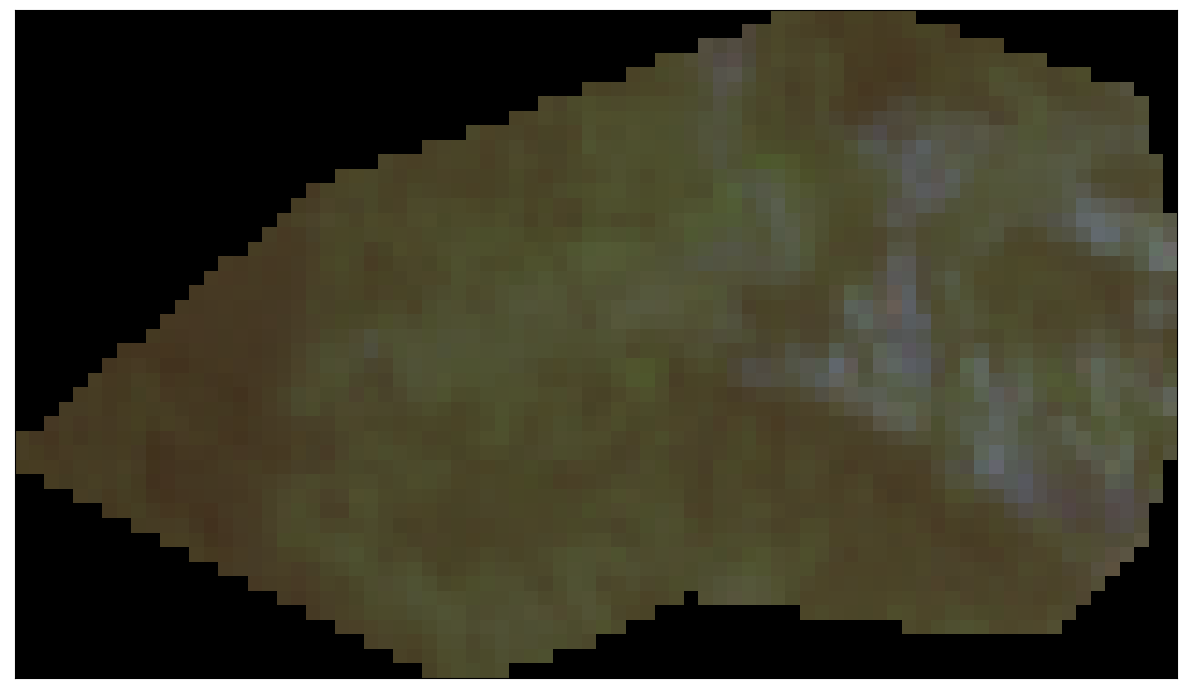

In [37]:
#visualize RGB
plot_image(all_bands_response[0][:, :, [0, 1, 2]], factor=3.5 / 1e4, clip_range=(0, 1))

In [39]:
all_bands_img = request_all_bands.get_data(save_data=True)

TypeError: get_data() got an unexpected keyword argument 'file'

In [41]:
file= r"C:\Users\Harith\EngenuityAI\SPE\SPE testing\SPE-testing\Sentinel-hub API\Data"

In [43]:
all_bands_response[0][:, :, [0, 1, 2]].save(file+"\gampola.tif")

AttributeError: 'numpy.ndarray' object has no attribute 'save'